# Setup

In [5]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

sns.set_theme()

torch.manual_seed(42)
np.random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Variables & Training/Equation Data

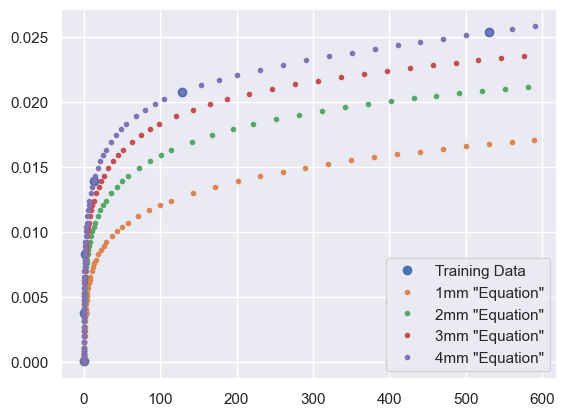

In [6]:
# Different variables for problem
r = 0.001                           # Radius of droplet in [m]
V = (4/3)*np.pi*(r**3)              # Volume of droplet in [m^3]
mu_0 = 1.256637*(1e-6)            # Permeability of free space [m*kg/(s*A)]
eta = 50                            # Viscosity in [Pa*s]
M = magnetization                   # Magnetization in [Oe]
H = magnetic_field                # Magnetic field in [KA/m]
dH_dx = magnetic_field_deriv    # Derivative of magnetic field with respect to distance in [KA/m^2]

t = np.array([0, 30.3468, 60.6936, 100.717, 281.498, 611.498])
x = np.array([0, 0.0159806, 0.0181084, 0.0197945, 0.0234893, 0.0265899])

# Acc_x is Matlab brushed data to emulate the actual graph without having to solve ODE :)
# numbers following t or x indicate diameter in mm
acc_t1 = np.array([
    0, 0.0141881878346854, 0.0283763756693708, 0.0425645635040563, 0.0567527513387417,
    0.127693690512169, 0.198634629685596, 0.269575568859023, 0.340516508032450, 0.549028513886979,
    0.757540519741507, 0.966052525596036, 1.17456453145056, 1.48276762290474, 1.79097071435892,
    2.09917380581309, 2.40737689726727, 2.93232585351207, 3.45727480975688, 3.98222376600168,
    4.50717272224649, 5.45531477128617, 6.40345682032586, 7.35159886936554, 8.29974091840522,
    10.0814634141448, 11.8631859098844, 13.6449084056240, 15.4266309013636, 18.8902991424888,
    22.3539673836139, 25.8176356247391, 29.2813038658643, 36.2270455036659, 43.1727871414674,
    50.1185287792690, 57.0642704170706, 71.3070132966999, 85.5497561763291, 99.7924990559584,
    114.035241935588, 143.084681028853, 172.134120122118, 201.183559215384, 230.232998308649,
    260.232998308649, 290.232998308649, 320.232998308649, 350.232998308649, 380.232998308649,
    410.232998308649, 440.232998308649, 470.232998308649, 500.232998308649, 530.232998308649,
    560.232998308649, 590.232998308649
]
)

acc_x1 = np.array([
    0, 0.0000499592117745538, 0.0000993627701134834, 0.000148213046154578, 0.000196512812001379,
    0.000429871800210202, 0.000650076540269180, 0.000857763966690795, 0.00105365400862708, 0.00156859634748614,
    0.00200664382954565, 0.00238336090366051, 0.00271184237578478, 0.00312946639357139, 0.00348354361449801,
    0.00378934423404296, 0.00405840289960797, 0.00445285862933801, 0.00478526585892468, 0.00507176733486661,
    0.00532417483393901, 0.00571596380443370, 0.00604469437011662, 0.00632757143972813, 0.00657699423863280,
    0.00697942497422202, 0.00731617103406459, 0.00760577569217383, 0.00786146134720767, 0.00828818269574487,
    0.00864478549126720, 0.00895162626167323, 0.00922306298477073, 0.00969071589349036, 0.0100815238784770,
    0.0104182875085352, 0.0107168781482719, 0.0112436364978613, 0.0116842086950727, 0.0120643279972374,
    0.0124016859532590, 0.0129940788332345, 0.0134896375311197, 0.0139165435906721, 0.0142942203827841,
    0.0146438019748596, 0.0149592800240695, 0.0152467661686819, 0.0155108933659508, 0.0157550474924074,
    0.0159819384066094, 0.0161937792953010, 0.0163923877015085, 0.0165792374423981, 0.0167555737325584,
    0.0169224612264692, 0.0170808135760898
]
)

acc_t2 = np.array([
    0, 0.00354704695867136, 0.00709409391734271, 0.0106411408760141, 0.0141881878346854,
    0.0319234226280422, 0.0496586574213990, 0.0673938922147558, 0.0851291270081125, 0.137257128471745,
    0.189385129935377, 0.241513131399009, 0.293641132862641, 0.370691905726185, 0.447742678589729,
    0.524793451453273, 0.601844224316817, 0.733081463378018, 0.864318702439219, 0.995555941500421,
    1.12679318056162, 1.36382869282154, 1.60086420508146, 1.83789971734139, 2.07493522960131,
    2.52036585353620, 2.96579647747110, 3.41122710140600, 3.85665772534090, 4.72257478562219,
    5.58849184590348, 6.45440890618478, 7.32032596646607, 9.05676137591647, 10.7931967853669,
    12.5296321948173, 14.2660676042676, 17.8267533241750, 21.3874390440823, 24.9481247639896,
    28.5088104838969, 35.7711702572133, 43.0335300305296, 50.2958898038460, 57.5582495771623,
    71.8070870335687, 86.0559244899751, 100.304761946381, 114.553599402788, 141.368289772438,
    168.182980142087, 194.997670511737, 221.812360881386, 251.812360881386, 281.812360881386,
    311.812360881386, 341.812360881386, 371.812360881386, 401.812360881386, 431.812360881386,
    461.812360881386, 491.812360881386, 521.812360881386, 551.812360881386, 581.812360881386
])
acc_x2 = np.array([
    0, 0.0000499592117745538, 0.0000993627701134834, 0.000148213046154578, 0.000196512812001379,
    0.000429871800210202, 0.000650076540269180, 0.000857763966690795, 0.00105365400862708, 0.00156859634748614,
    0.00200664382954565, 0.00238336090366051, 0.00271184237578478, 0.00312946639357139, 0.00348354361449801,
    0.00378934423404296, 0.00405840289960797, 0.00445285862933801, 0.00478526585892468, 0.00507176733486661,
    0.00532417483393901, 0.00571596380443370, 0.00604469437011662, 0.00632757143972813, 0.00657699423863280,
    0.00697942497422202, 0.00731617103406459, 0.00760577569217383, 0.00786146134720767, 0.00828818269574487,
    0.00864478549126720, 0.00895162626167323, 0.00922306298477073, 0.00969071589349036, 0.0100815238784770,
    0.0104182875085352, 0.0107168781482719, 0.0112436364978613, 0.0116842086950727, 0.0120643279972374,
    0.0124016859532590, 0.0129940788332345, 0.0134896375311197, 0.0139165435906721, 0.0142942203827841,
    0.0149303269926933, 0.0154603660877502, 0.0159138835003558, 0.0163119039154504, 0.0169501657819180,
    0.0174773231052882, 0.0179239841187606, 0.0183128672456461, 0.0186955911933842, 0.0190329873730012,
    0.0193342689450249, 0.0196063909602334, 0.0198543047851438, 0.0200818157422775, 0.0202920158614401,
    0.0204873966755472, 0.0206699269387967, 0.0208412351392776, 0.0210026893669623, 0.0211554408170059
]
)

acc_t3 = np.array([
    0, 0.00157646531496505, 0.00315293062993009, 0.00472939594489514, 0.00630586125986019,
    0.0141881878346854, 0.0220705144095107, 0.0299528409843359, 0.0378351675591611, 0.0610031682097423,
    0.0841711688603234, 0.107339169510905, 0.130507170161486, 0.164751958100866, 0.198996746040246,
    0.233241533979626, 0.267486321919006, 0.325813983724076, 0.384141645529147, 0.442469307334217,
    0.500796969139288, 0.606146085699397, 0.711495202259507, 0.816844318819617, 0.922193435379726,
    1.12016260157330, 1.31813176776688, 1.51610093396045, 1.71407010015403, 2.09892212694628,
    2.48377415373852, 2.86862618053077, 3.25347820732301, 4.02522727819077, 4.79697634905854,
    5.56872541992630, 6.34047449079407, 7.92300147742125, 9.50552846404844, 11.0880554506756,
    12.6705824373028, 15.8982978921189, 19.1260133469350, 22.3537288017510, 25.5814442565671,
    31.9142609038637, 38.2470775511602, 44.5798941984568, 50.9127108457533, 62.8303510100452,
    74.7479911743371, 86.6656313386290, 98.5832715029209, 120.650332612259, 142.717393721596,
    164.784454830934, 186.851515940272, 216.851515940272, 246.851515940272, 276.851515940272,
    306.851515940272, 336.851515940272, 366.851515940272, 396.851515940272, 426.851515940272,
    456.851515940272, 486.851515940272, 516.851515940272, 546.851515940272, 576.851515940272
]
)

acc_x3 = np.array([
    0, 0.0000499592117745539, 0.0000993627701134834, 0.000148213046154578, 0.000196512812001379,
    0.000429871800210202, 0.000650076540269180, 0.000857763966690795, 0.00105365400862708, 0.00156859634748774,
    0.00200664382954838, 0.00238336090366404, 0.00271184237578891, 0.00312946639357517, 0.00348354361450150,
    0.00378934423404624, 0.00405840289961108, 0.00445285862934117, 0.00478526585892787, 0.00507176733486982,
    0.00532417483394223, 0.00571596380443685, 0.00604469437011973, 0.00632757143973120, 0.00657699423863586,
    0.00697942497422508, 0.00731617103406764, 0.00760577569217689, 0.00786146134721075, 0.00828818269574796,
    0.00864478549127031, 0.00895162626167638, 0.00922306298477390, 0.00969071589349347, 0.0100815238784801,
    0.0104182875085383, 0.0107168781482750, 0.0112436364978643, 0.0116842086950757, 0.0120643279972404,
    0.0124016859532621, 0.0129940788332385, 0.0134896375311244, 0.0139165435906773, 0.0142942203827897,
    0.0149303269926983, 0.0154603660877548, 0.0159138835003601, 0.0163119039154545, 0.0169501657819215,
    0.0174773231052912, 0.0179239841187633, 0.0183128672456486, 0.0189225754085257, 0.0194223998704160,
    0.0198436236541720, 0.0202100571400069, 0.0206438205007219, 0.0210186365795598, 0.0213492627819547,
    0.0216463999678818, 0.0219169874275932, 0.0221659687382452, 0.0223973407671536, 0.0226142096964053,
    0.0228189280819170, 0.0230134069649608, 0.0231992127953378, 0.0233776327609875, 0.0235497125028056
]
)

acc_t4 = np.array([
    0, 0.000886761739667839, 0.00177352347933568, 0.00266028521900352, 0.00354704695867136,
    0.00798085565701055, 0.0124146643553497, 0.0168484730536889, 0.0212822817520281, 0.0343142821179362,
    0.0473462824838442, 0.0603782828497522, 0.0734102832156603, 0.0926729764315463, 0.111935669647432,
    0.131198362863318, 0.150461056079204, 0.183270365844505, 0.216079675609805, 0.248888985375105,
    0.281698295140405, 0.340957173205386, 0.400216051270366, 0.459474929335346, 0.518733807400327,
    0.630091463384051, 0.741449119367775, 0.852806775351500, 0.964164431335224, 1.18064369640555,
    1.39712296147587, 1.61360222654619, 1.83008149161652, 2.26419034397912, 2.69829919634171,
    3.13240804870431, 3.56651690106691, 4.45668833104374, 5.34685976102057, 6.23703119099740,
    7.12720262097423, 8.94279256430332, 10.7583825076324, 12.5739724509615, 14.3895623942906,
    17.9517717583922, 21.5139811224938, 25.0761904865954, 28.6383998506970, 35.3420724431094,
    42.0457450355218, 48.7494176279342, 55.4530902203466, 67.8658120943420, 80.2785339683375,
    92.6912558423329, 105.103977716328, 129.040339022249, 152.976700328169, 176.913061634089,
    200.849422940009, 230.849422940009, 260.849422940009, 290.849422940009, 320.849422940009,
    350.849422940009, 380.849422940009, 410.849422940009, 440.849422940009, 470.849422940009,
    500.849422940009, 530.849422940009, 560.849422940009, 590.849422940009
]
)

acc_x4 = np.array([
    0, 0.0000499592117745538, 0.0000993627701134834, 0.000148213046154578, 0.000196512812001379,
    0.000429871800210202, 0.000650076540269180, 0.000857763966690795, 0.00105365400862708, 0.00156859634748614,
    0.00200664382954565, 0.00238336090366051, 0.00271184237578478, 0.00312946639357139, 0.00348354361449801,
    0.00378934423404296, 0.00405840289960797, 0.00445285862933801, 0.00478526585892468, 0.00507176733486661,
    0.00532417483393901, 0.00571596380443370, 0.00604469437011662, 0.00632757143972813, 0.00657699423863280,
    0.00697942497422202, 0.00731617103406459, 0.00760577569217383, 0.00786146134720767, 0.00828818269574487,
    0.00864478549126720, 0.00895162626167323, 0.00922306298477073, 0.00969071589349036, 0.0100815238784770,
    0.0104182875085352, 0.0107168781482719, 0.0112436364978613, 0.0116842086950727, 0.0120643279972374,
    0.0124016859532590, 0.0129940788332345, 0.0134896375311197, 0.0139165435906721, 0.0142942203827841,
    0.0149303269926933, 0.0154603660877502, 0.0159138835003558, 0.0163119039154504, 0.0169501657819180,
    0.0174773231052882, 0.0179239841187606, 0.0183128672456461, 0.0189225754085233, 0.0194223998704138,
    0.0198436236541699, 0.0202100571400049, 0.0208084673747689, 0.0212990282170032, 0.0217151413179661,
    0.0220821033397627, 0.0224929438401419, 0.0228606353358732, 0.0231968192945811, 0.0235097202671726,
    0.0238047131657571, 0.0240858518617269, 0.0243562484360631, 0.0246182573413305, 0.0248735878583696,
    0.0251235400135597, 0.0253690539620651, 0.0256107602665230, 0.0258490061975504
]
)

# Train for 1mm
train_t = t  # Time in (s)
train_x = x + 0.0002*np.random.randn(6) # Distance (m)

# Train with exact data points, where it is obtained every 6th point
four = lambda lst: lst[1::14]
train_t = four(acc_t4)
train_x = four(acc_x4)
# train_x = []
# for item in train_x_pre:
#     train_x.append(np.log(item))
# train_x = np.array(train_x)


# Plot training data and equation data
# plt.plot(t, x, 'o')
plt.plot(train_t, train_x, 'o')
plt.plot(acc_t1, acc_x1, '.')
plt.plot(acc_t2, acc_x2, '.')
plt.plot(acc_t3, acc_x3, '.')
plt.plot(acc_t4, acc_x4, '.')
plt.legend(['Training Data', '1mm \"Equation\"', '2mm \"Equation\"', '3mm \"Equation\"', '4mm \"Equation\"'])
# plt.ylabel('Position (m)')
# plt.xlabel('Time (s)')

# Physics Loss Model

In [7]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1200, steps=1200,).view(-1, 1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    dx = grad(xs, ts)[0]
    pde = (V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta) - dx
    
    return torch.mean(pde**2)
    

Epoch 0/10000, loss: 245195765918466048.00
Epoch 1000/10000, loss: 788103424.00
Epoch 2000/10000, loss: 131199440.00
Epoch 3000/10000, loss: 41484084.00
Epoch 4000/10000, loss: 16338564.00
Epoch 5000/10000, loss: 7151434.50
Epoch 6000/10000, loss: 3361651.00
Epoch 7000/10000, loss: 1624299.62
Epoch 8000/10000, loss: 802585.31
Epoch 9000/10000, loss: 1.00


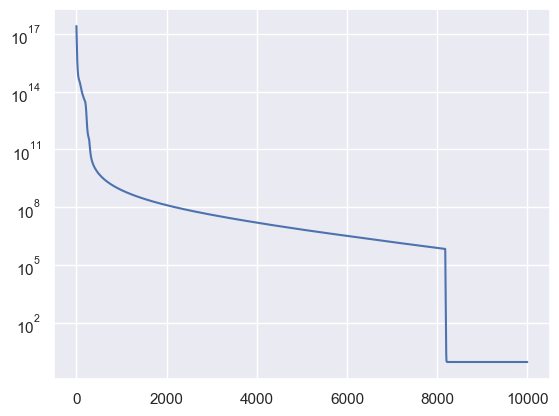

In [8]:
net = Net(1,1, loss2=physics_loss, epochs=10000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(train_t, train_x)
plt.plot(losses)
plt.yscale('log')

In [9]:
# ts = np.linspace(0, 800, 800)
# preds = net.predict(ts)

# plt.plot(train_t, train_x, 'o')
# plt.plot(ts, preds, alpha=0.8)
# plt.legend(labels=['Training data', 'PINN'])
# plt.ylabel('Position (m)')
# plt.xlabel('Time (s)')

# Learning Rate Testing

Epoch 0/10000, loss: 399002059145216.00
Epoch 1000/10000, loss: 274502.53
Epoch 2000/10000, loss: 197114.61
Epoch 3000/10000, loss: 125245.34
Epoch 4000/10000, loss: 74096.39


KeyboardInterrupt: 

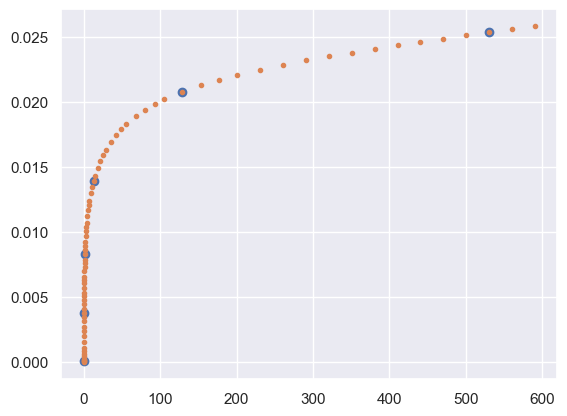

In [10]:
plt.plot(train_t, train_x, 'o')
# plt.plot(acc_t1, acc_x1, '.')
# plt.plot(acc_t2, acc_x2, '.')
# plt.plot(acc_t3, acc_x3, '.')
plt.plot(acc_t4, acc_x4, '.')
for rate in [1e-3, 1e-4, 1e-5, 1e-6]:
    net = Net(1,1, loss2=physics_loss, epochs=10000, loss2_weight=1, lr=rate).to(DEVICE)
    losses = net.fit(train_t, train_x)
    
    ts = np.linspace(0, 1200, 1200)
    preds = net.predict(ts)

    plt.plot(ts, preds, alpha=0.8)
    plt.ylabel('Position (m)')
    plt.ylim(0, 0.03)
    plt.xlabel('Time (s)')
plt.legend(['Training Data', '4mm \"Equation\"', '1e-3', '1e-4', '1e-5', '1e-6'])

# Epoch Testing

Epoch 0/5000, loss: 8427109727037814734848.00
Epoch 500/5000, loss: 8387597958657033109504.00
Epoch 1000/5000, loss: 8372121338537574400000.00
Epoch 1500/5000, loss: 8357934436761403916288.00
Epoch 2000/5000, loss: 8338752480048526131200.00
Epoch 2500/5000, loss: 8315965391833938264064.00
Epoch 3000/5000, loss: 8299166965223846313984.00
Epoch 3500/5000, loss: 8282974272763635695616.00
Epoch 4000/5000, loss: 8267393506902794043392.00
Epoch 4500/5000, loss: 8251565043062447013888.00
Epoch 0/8000, loss: 3050879509898199040.00
Epoch 800/8000, loss: 24076812812288.00
Epoch 1600/8000, loss: nan
Epoch 2400/8000, loss: nan
Epoch 3200/8000, loss: nan
Epoch 4000/8000, loss: nan
Epoch 4800/8000, loss: nan
Epoch 5600/8000, loss: nan
Epoch 6400/8000, loss: nan
Epoch 7200/8000, loss: nan


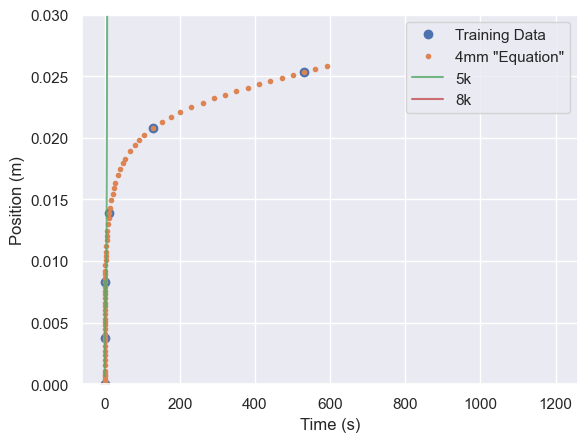

In [ ]:
plt.plot(train_t, train_x, 'o')
# plt.plot(acc_t1, acc_x1, '.')
# plt.plot(acc_t2, acc_x2, '.')
# plt.plot(acc_t3, acc_x3, '.')
plt.plot(acc_t4, acc_x4, '.')
for epoch in [5000, 80000]:
    net = Net(1,1, loss2=physics_loss, epochs=epoch, loss2_weight=1, lr=1e-5).to(DEVICE)
    losses = net.fit(train_t, train_x)
    
    ts = np.linspace(0, 1200, 1200)
    preds = net.predict(ts)

    plt.plot(ts, preds, alpha=0.8)
    plt.ylabel('Position (m)')
    plt.ylim(0, 0.03)
    plt.xlabel('Time (s)')
plt.legend(['Training Data', '4mm \"Equation\"', '5k', '8k', '11k', '14k', '17k'])

# Loss Weight Testing

Epoch 0/14000, loss: 122559504.00
Epoch 1400/14000, loss: nan
Epoch 2800/14000, loss: nan
Epoch 4200/14000, loss: nan
Epoch 5600/14000, loss: nan
Epoch 7000/14000, loss: nan
Epoch 8400/14000, loss: nan
Epoch 9800/14000, loss: nan
Epoch 11200/14000, loss: nan
Epoch 12600/14000, loss: nan
Epoch 0/14000, loss: 193583344.00
Epoch 1400/14000, loss: 1.00
Epoch 2800/14000, loss: 1.00
Epoch 4200/14000, loss: 1.00
Epoch 5600/14000, loss: 1.00
Epoch 7000/14000, loss: 1.00
Epoch 8400/14000, loss: 1.00
Epoch 9800/14000, loss: 1.00
Epoch 11200/14000, loss: 1.00
Epoch 12600/14000, loss: 1.00


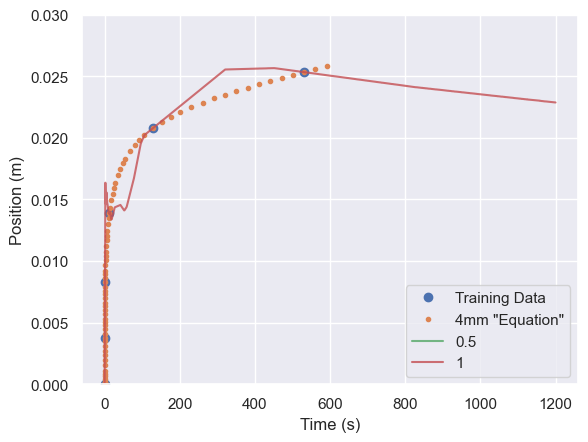

In [ ]:
plt.plot(train_t, train_x, 'o')
# plt.plot(acc_t1, acc_x1, '.')
# plt.plot(acc_t2, acc_x2, '.')
# plt.plot(acc_t3, acc_x3, '.')
plt.plot(acc_t4, acc_x4, '.')
for weight in [0.5, 1]:
    net = Net(1,1, loss2=physics_loss, epochs=14000, loss2_weight=weight, lr=1e-5).to(DEVICE)
    losses = net.fit(train_t, train_x)
    
    ts = np.linspace(0, 1200, 1200)
    preds = net.predict(ts)

    plt.plot(ts, preds, alpha=0.8)
    plt.ylabel('Position (m)')
    plt.ylim(0, 0.03)
    plt.xlabel('Time (s)')
plt.legend(['Training Data', '4mm \"Equation\"', '0.5', '1', '2', '4', '8'])

# "Ideal" Configuration (based on closest values from before)

Epoch 0/17000, loss: 11274500458343649247232.00
Epoch 1700/17000, loss: 11270891949142218637312.00
Epoch 3400/17000, loss: 11268349667152567992320.00
Epoch 5100/17000, loss: 11266091111939441688576.00
Epoch 6800/17000, loss: 11264129794301721837568.00
Epoch 8500/17000, loss: 11262259674556456239104.00
Epoch 10200/17000, loss: 11261705731802289668096.00
Epoch 11900/17000, loss: 11259591291777239220224.00
Epoch 13600/17000, loss: 11257468970452840873984.00
Epoch 15300/17000, loss: 11255272339734590914560.00


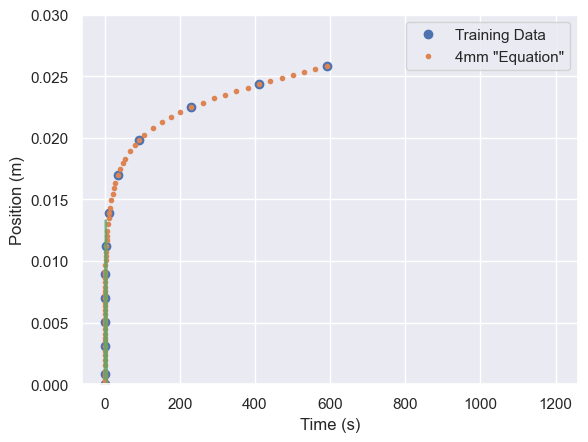

In [ ]:
plt.plot(train_t, train_x, 'o')
# plt.plot(acc_t1, acc_x1, '.')
# plt.plot(acc_t2, acc_x2, '.')
# plt.plot(acc_t3, acc_x3, '.')
plt.plot(acc_t4, acc_x4, '.')
net = Net(1,1, loss2=physics_loss, epochs=17000, loss2_weight=0.5, lr=1e-6).to(DEVICE)
losses = net.fit(train_t, train_x)

ts = np.linspace(0, 1200, 1200)
preds = net.predict(ts)

plt.plot(ts, preds, alpha=0.8)
plt.ylabel('Position (m)')
plt.ylim(0, 0.03)
plt.xlabel('Time (s)')
plt.legend(['Training Data', '4mm \"Equation\"'])

# Functions

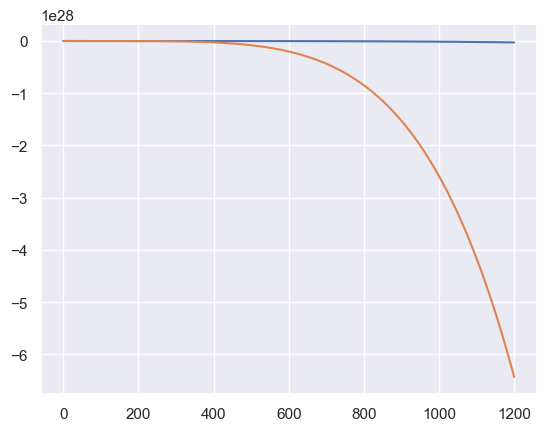

: 

In [ ]:
ts = np.linspace(0, 1200, 1200)
mag = magnetic_field(ts)
dmag = magnetic_field_deriv(ts)
plt.plot(ts, mag)
plt.plot(ts, dmag)

C:\Users\Samuel\AppData\Local\Temp\ipykernel_42564\2357440267.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  u = ((V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta))


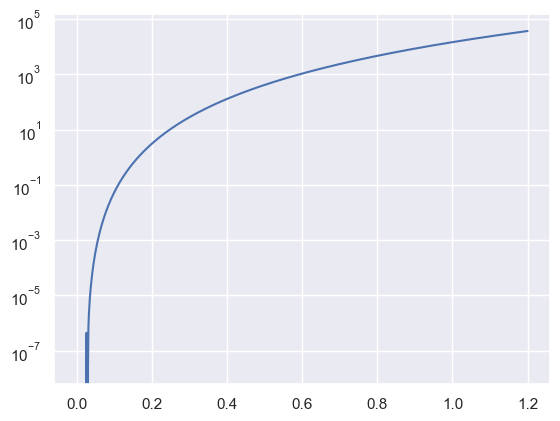

In [ ]:
xs = np.linspace(0, 1.2, 1000)
u = ((V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta))

plt.plot(xs, u)
plt.yscale('log')